A Gentle Introduction to `torch.autograd`
=========================================

`torch.autograd` is PyTorch's automatic differentiation engine that
powers neural network training. In this section, you will get a
conceptual understanding of how autograd helps a neural network train.

Background
----------

Neural networks (NNs) are a collection of nested functions that are
executed on some input data. These functions are defined by *parameters*
(consisting of weights and biases), which in PyTorch are stored in
tensors.

Training a NN happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess
about the correct output. It runs the input data through each of its
functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters
proportionate to the error in its guess. It does this by traversing
backwards from the output, collecting the derivatives of the error with
respect to the parameters of the functions (*gradients*), and optimizing
the parameters using gradient descent. For a more detailed walkthrough
of backprop, check out this [video from
3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

Usage in PyTorch
----------------

Let\'s take a look at a single training step. For this example, we load
a pretrained resnet18 model from `torchvision`. We create a random data
tensor to represent a single image with 3 channels, and height & width
of 64, and its corresponding `label` initialized to some random values.
Label in pretrained models has shape (1,1000).

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>This tutorial works only on the CPU and will not work on GPU devices (even if tensors are moved to CUDA).</p>

</div>



In [51]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


Next, we run the input data through the model through each of its layers
to make a prediction. This is the **forward pass**.


In [52]:
prediction = model(data) # forward pass

We use the model\'s prediction and the corresponding label to calculate
the error (`loss`). The next step is to backpropagate this error through
the network. Backward propagation is kicked off when we call
`.backward()` on the error tensor. Autograd then calculates and stores
the gradients for each model parameter in the parameter\'s `.grad`
attribute.


In [53]:
loss = (prediction - labels).sum()
loss.backward() # backward pass

Next, we load an optimizer, in this case SGD with a learning rate of
0.01 and
[momentum](https://medium.com/data-science/stochastic-gradient-descent-with-momentum-a84097641a5d)
of 0.9. We register all the parameters of the model in the optimizer.


In [54]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Finally, we call `.step()` to initiate gradient descent. The optimizer
adjusts each parameter by its gradient stored in `.grad`.


In [55]:
optim.step() #gradient descent

At this point, you have everything you need to train your neural
network. The below sections detail the workings of autograd - feel free
to skip them.


------------------------------------------------------------------------


Differentiation in Autograd
===========================

Let\'s take a look at how `autograd` collects gradients. We create two
tensors `a` and `b` with `requires_grad=True`. This signals to
`autograd` that every operation on them should be tracked.


In [56]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor `Q` from `a` and `b`.

$$Q = 3a^3 - b^2$$


In [57]:
Q = 3*a**3 - b**2

Let\'s assume `a` and `b` to be parameters of an NN, and `Q` to be the
error. In NN training, we want gradients of the error w.r.t. parameters,
i.e.

$$\frac{\partial Q}{\partial a} = 9a^2$$

$$\frac{\partial Q}{\partial b} = -2b$$

When we call `.backward()` on `Q`, autograd calculates these gradients
and stores them in the respective tensors\' `.grad` attribute.

We need to explicitly pass a `gradient` argument in `Q.backward()`
because it is a vector. `gradient` is a tensor of the same shape as `Q`,
and it represents the gradient of Q w.r.t. itself, i.e.

$$\frac{dQ}{dQ} = 1$$

Equivalently, we can also aggregate Q into a scalar and call backward
implicitly, like `Q.sum().backward()`.


In [58]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in `a.grad` and `b.grad`


In [59]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


Computational Graph
===================

Conceptually, autograd keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

-   run the requested operation to compute a resulting tensor, and
-   maintain the operation's *gradient function* in the DAG.

The backward pass kicks off when `.backward()` is called on the DAG
root. `autograd` then:

-   computes the gradients from each `.grad_fn`,
-   accumulates them in the respective tensor's `.grad` attribute, and
-   using the chain rule, propagates all the way to the leaf tensors.

Below is a visual representation of the DAG in our example. In the
graph, the arrows are in the direction of the forward pass. The nodes
represent the backward functions of each operation in the forward pass.
The leaf nodes in blue represent our leaf tensors `a` and `b`.

![](https://pytorch.org/tutorials/_static/img/dag_autograd.png)

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>An important thing to note is that the graph is recreated from scratch; after each<code>.backward()</code> call, autograd starts populating a new graph. This isexactly what allows you to use control flow statements in your model;you can change the shape, size and operations at every iteration ifneeded.</p>

</div>

Exclusion from the DAG
----------------------

`torch.autograd` tracks operations on all tensors which have their
`requires_grad` flag set to `True`. For tensors that don't require
gradients, setting this attribute to `False` excludes it from the
gradient computation DAG.

The output tensor of an operation will require gradients even if only a
single input tensor has `requires_grad=True`.


In [60]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients?: {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients?: False
Does `b` require gradients?: True


In a NN, parameters that don\'t compute gradients are usually called
**frozen parameters**. It is useful to \"freeze\" part of your model if
you know in advance that you won\'t need the gradients of those
parameters (this offers some performance benefits by reducing autograd
computations).

In finetuning, we freeze most of the model and typically only modify the
classifier layers to make predictions on new labels. Let\'s walk through
a small example to demonstrate this. As before, we load a pretrained
resnet18 model, and freeze all the parameters.


In [61]:
from torch import nn, optim

model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

Let\'s say we want to finetune the model on a new dataset with 10
labels. In resnet, the classifier is the last linear layer `model.fc`.
We can simply replace it with a new linear layer (unfrozen by default)
that acts as our classifier.


In [62]:
model.fc = nn.Linear(512, 10)

Now all parameters in the model, except the parameters of `model.fc`,
are frozen. The only parameters that compute gradients are the weights
and bias of `model.fc`.


In [63]:
# Optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Notice although we register all the parameters in the optimizer, the
only parameters that are computing gradients (and hence updated in
gradient descent) are the weights and bias of the classifier.

The same exclusionary functionality is available as a context manager in
[torch.no\_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html)


------------------------------------------------------------------------


In [64]:
import torch

In [65]:
# first  we create a   tensor  of  which   derivative we want to calculate
x=torch.tensor(3.0,requires_grad=True)
# defining function depandant variabel 'y'
y=x**2


##lets understand   what is happening here
* first of all we  define  a  parameter "requires_grad=True" that  signals autograd   that  every   operation   on  that   variabel x   should be traced  
> as  we  know   that  pytorch   uses   Dynamic graphs concept

> x=torch.tensor(3.0,requires_grad=True) here  x  work like a   leaf node of     graph    from that   what  every  variabels  we  defined   using x  will  be  traced   

* When requires_grad=True is set on a tensor, PyTorch’s autograd engine tracks all subsequent differentiable operations that involve this tensor and dynamically builds a computation graph at runtime. The tensor itself is a leaf node, and any tensors derived from it become part of the graph. Gradients are computed only when backward() is called.

## 1) Simple Linear Graph (Single Input, Linear Flow)

**Code:**
```python
x = torch.tensor(3.0, requires_grad=True)
y = x * 2
z = y + 5
out = z ** 2
````

**Computation Graph:**

```
        x (leaf)
        │
        │ (*2)
        ▼
        y
        │ (+5)
        ▼
        z
        │ (**2)
        ▼
       out
```

**Backward Flow:**

```
out → z → y → x
```

---

## Legend

* **leaf**: Tensor with `requires_grad=True` and `grad_fn=None`
* **operation**: Differentiable PyTorch operation
* **detach()**: Explicitly breaks the computation graph
* **Backward**: Gradients flow opposite to the forward arrows


###  now lets calculate derivative i.e dy/dx

When we call .backward() on Q, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

We need to explicitly pass a gradient argument in Q.backward() because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

In [66]:
y.backward()
print(x.grad)

tensor(6.)


#  lets  use another exampel

In [67]:
x-torch.tensor(4.0,requires_grad=True)
y=x**2
print(y)
z=torch.sin(y)
print(z)

tensor(9., grad_fn=<PowBackward0>)
tensor(0.4121, grad_fn=<SinBackward0>)


In [ ]:
y.backward()
print(x.grad)
z.backward()
print(x.grad)

### Computation Graph

```text
x (leaf)
 │
 │ (**2)
 ▼
y
 │ sin()
 ▼
z
```

---

### Explanation

* `x` is a **leaf tensor** with `requires_grad=True`
* `y = x²` creates a tracked operation
* `z = sin(y)` adds another tracked operation
* Autograd builds the graph **forward**
* Gradients flow **backward** using the chain rule:

[
\frac{dz}{dx} = \cos(x^2) \cdot 2x
]




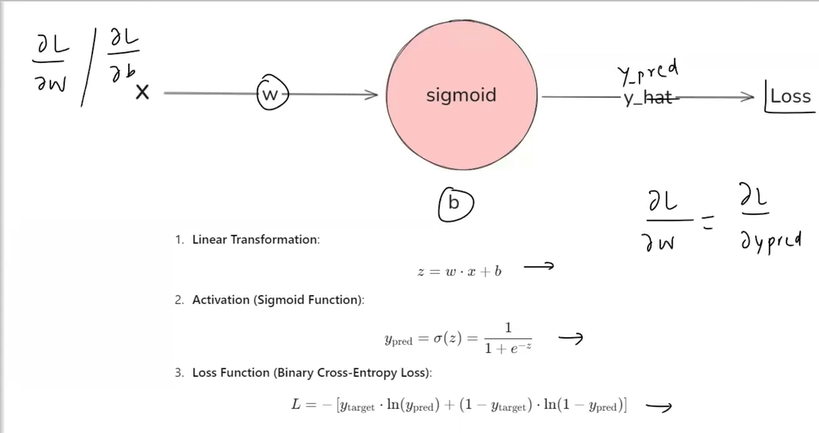








###  This is the forward pass + backward pass (gradient flow) of a single-neuron binary classification model,
> to optmise  weight (in order to minimize loss) we need  dl/dw (that is derivative of loss function wrt tunabel parameters of NN)
> it is very complicated  to manualley   calcualte that
> but using autograd it is very simpel  as it  automaticalley  calcualte   derivative of    loss function (root node)  wrt all teh   intermedate nodes  also with  leaf node  whe  we do   # loss.backward()  (When we call .backward() on loss, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

)
>now  we can acess   dl/dw,dl/db,dl/dz,dl/dy    but we are onley intrested in dl/dw   so we do w.gradient()











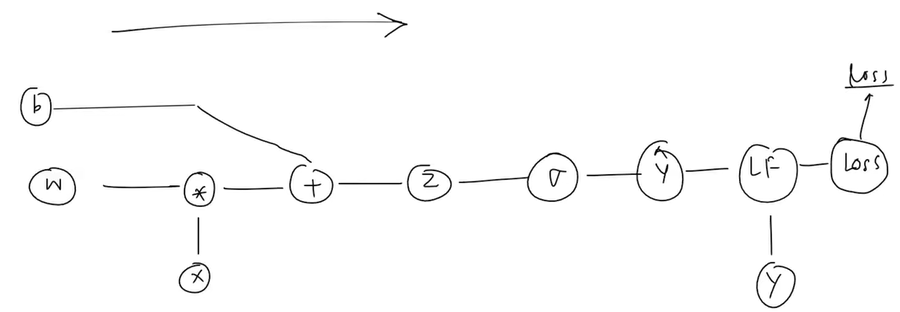




### this is the computation  related to    weight  optimization process

In [ ]:
x = torch.tensor(6.7)
y = torch.tensor(0.0)
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


In [ ]:
z = w*x + b
z

In [ ]:
y_pred = torch.sigmoid(z)
y_pred

In [ ]:
import torch.nn.functional as F  # ignore this

loss = F.binary_cross_entropy(y_pred, y)
loss


In [ ]:
loss.backward()  # now     gradient of  all   intermedate  and leaf  nodes in   graph  are stored in their  respective gradient   and we can acee  them using .grad

In [ ]:
print(w.grad,b.grad)

#  till   now  we  use  onley  scaler  (2D) x-y  
#                  or
# NN with onley one input nuron that inputs scaler (x) and  gets predicted value  Y  X-Y plane
# but  generalley  NN  are multidimensional functions   took  multipule  variabels in input   may be a  vecot or a  matrix of  higher  dimensional  tensor (image and video)   we can easiley calculate   their  gradients  

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

In [ ]:
y = (x**2).mean()
y


In [ ]:
y.backward()
x.grad

### Clearing Gradients — Quick Explanation

In PyTorch, **gradients accumulate by default**.

---

### Why clearing gradients is necessary

Every time you call:

```python
loss.backward()
```

PyTorch **adds** new gradients to existing ones:

```python
w.grad += new_gradient
```

If you do **not clear them**, gradients from previous iterations will **carry over**, leading to **incorrect updates**.

---

### Correct training pattern

```python
optimizer.zero_grad()   # clear old gradients
loss.backward()         # compute new gradients
optimizer.step()        # update parameters
```

---

### What `zero_grad()` does

* Sets all `.grad` values to **zero**
* Prevents gradient accumulation across iterations
* Ensures each backward pass uses **only current loss**

---

### When you *don’t* clear gradients (on purpose)

Gradient accumulation is sometimes intentional:

* Large batch training with small GPU memory
* Accumulating gradients over multiple forward passes

---

### One-line intuition

> PyTorch remembers gradients unless you explicitly erase them.


# Disabling Gradient Tracking

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
y = x ** 2
y.backward()
print(x.grad)      # tensor(4.)

x.requires_grad_(False)
y = x ** 2
# y.backward() ❌ error
# Stops autograd from tracking x. New operations on x are not part of the graph.
#  z shares the same value as x but is disconnected from the graph.
# Gradients flow through x, not through z

In [ ]:
x = torch.tensor(2.0, requires_grad=True)
z = x.detach()

y = x ** 2
y1 = z ** 2

y.backward()
# y1.backward() ❌ error


Optional Reading - Vector Calculus using `autograd`
===================================================

Mathematically, if you have a vector valued function
$\vec{y}=f(\vec{x})$, then the gradient of $\vec{y}$ with respect to
$\vec{x}$ is a Jacobian matrix $J$:

$$\begin{aligned}
J
=
 \left(\begin{array}{cc}
 \frac{\partial \bf{y}}{\partial x_{1}} &
 ... &
 \frac{\partial \bf{y}}{\partial x_{n}}
 \end{array}\right)
=
\left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)
\end{aligned}$$

Generally speaking, `torch.autograd` is an engine for computing
vector-Jacobian product. That is, given any vector $\vec{v}$, compute
the product $J^{T}\cdot \vec{v}$

If $\vec{v}$ happens to be the gradient of a scalar function
$l=g\left(\vec{y}\right)$:

$$\vec{v}
 =
 \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$$

then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

$$\begin{aligned}
J^{T}\cdot \vec{v} = \left(\begin{array}{ccc}
 \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
 \vdots & \ddots & \vdots\\
 \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
 \end{array}\right)\left(\begin{array}{c}
 \frac{\partial l}{\partial y_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial y_{m}}
 \end{array}\right) = \left(\begin{array}{c}
 \frac{\partial l}{\partial x_{1}}\\
 \vdots\\
 \frac{\partial l}{\partial x_{n}}
 \end{array}\right)
\end{aligned}$$

This characteristic of vector-Jacobian product is what we use in the
above example; `external_grad` represents $\vec{v}$.
